In [1]:
%matplotlib inline
import dataclasses
from typing import *

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
import torchvision

In [2]:
training_data_set = torchvision.datasets.MNIST('./dataset/mnist/training.pt', train=True, download=True)
test_data_set = torchvision.datasets.MNIST('./dataset/mnist/test.pt', train=False, download=True)

Number of samples in the training set: 60000
Number of samples in the test set: 10000
<PIL.Image.Image image mode=L size=28x28 at 0x1CF3AD36240> -> tensor(5)


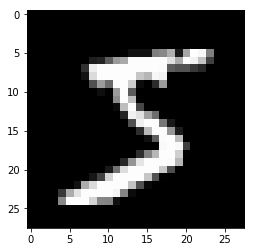

In [3]:
"""
Observing some of the data
"""
print("Number of samples in the training set:", len(training_data_set))
print("Number of samples in the test set:", len(test_data_set))
image, target = training_data_set[0]
print(image, "->", target)
plt.imshow(image)

In [4]:
"""
How to transform the data into vectors
"""
pipeline = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.2, 0.2, 0.2])
])
xs = pipeline(image)
xs.shape

# TODO - it is not something ? we should learn the transformation on the training set, then stop doing this...

torch.Size([1, 28, 28])

In [5]:
"""
Working with data loader for images
"""

# You need to transform the data to vectors to put it inside a data loader
training_data_set.transform = pipeline
test_data_set.transform = pipeline

data_loader = DataLoader(training_data_set, batch_size=2, shuffle=True)
for images, targets in data_loader:
    print(images)
    print(targets)
    break

tensor([[[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          ...,
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]],


        [[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          ...,
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]]])
tensor([9, 4])


[Epoch 0] Training loss: 265.28029422461987
[Epoch 0] Accuracy: 54430/60000 (90.72%)
[Epoch 1] Training loss: 197.39200666546822
[Epoch 1] Accuracy: 54716/60000 (91.19%)
[Epoch 2] Training loss: 194.15217050909996
[Epoch 2] Accuracy: 53343/60000 (88.91%)
[Epoch 3] Training loss: 187.23537728190422
[Epoch 3] Accuracy: 55321/60000 (92.20%)
[Epoch 4] Training loss: 184.5807300209999
[Epoch 4] Accuracy: 52658/60000 (87.76%)


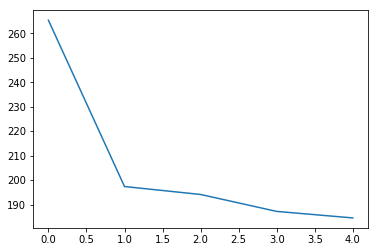

In [6]:
"""
Training a basic Linear classifier for images
"""

class LinearClassifier(nn.Module):
    def __init__(self, width=28, height=28):
        super().__init__()
        self.fc = nn.Linear(width * height, 10)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

def train(model, training_data_set, test_data_set, epoch_count=10):
    training_data_set.transform = pipeline
    test_data_set.transform = pipeline  
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    training_data_loader = DataLoader(training_data_set, batch_size=100, shuffle=True)
    test_data_loader = DataLoader(training_data_set, batch_size=100, shuffle=True)

    losses = []

    for epoch in range(epoch_count):
        cumulative_loss = 0.
        model.train()
        for images, targets in training_data_loader:
            optimizer.zero_grad()
            got = model(images, with_softmax=False)
            loss = criterion(got, targets)
            cumulative_loss += loss.item()
            loss.backward()
            optimizer.step()

        print("[Epoch {0}] Training loss: {1}".format(epoch, cumulative_loss))
        losses.append(cumulative_loss)

        correct = 0
        total = 0
        model.eval()
        for images, targets in test_data_loader:
            got = model(images, with_softmax=True)
            predicted = torch.argmax(got, dim=-1)
            predicted = predicted.view(-1)
            targets = targets.view(-1)
            correct += (predicted == targets).sum().item()
            total += len(targets)

        print("[Epoch {0}] Accuracy: {1}/{2} ({3:.2f}%)".format(epoch, correct, total, 100 * correct/total))

    plt.plot(losses)
    plt.show()
    
linear_model = LinearClassifier()
train(linear_model, training_data_set, test_data_set, epoch_count=5)

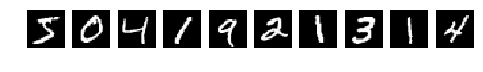

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [7]:
"""
Trying the model
"""

def predict(model, data_set, image_indexes):
    fig, ax = plt.subplots(figsize=(8, 8), ncols=len(image_indexes))
    predicted = []
    training_data_set.transform = None
    for image_idx in image_indexes:
        image, target = data_set[image_idx]
        xs = pipeline(image)
        xs = xs.unsqueeze(dim=0)
        ys = model(xs, with_softmax=True)
        predicted.append(torch.argmax(ys, dim=-1).item())
        ax[image_idx].imshow(image)
        ax[image_idx].set_axis_off()
    plt.show()
    print(predicted)

predict(linear_model, training_data_set, range(10))

[Epoch 0] Training loss: 256.35818289220333
[Epoch 0] Accuracy: 55485/60000 (92.47%)
[Epoch 1] Training loss: 153.93555337190628
[Epoch 1] Accuracy: 56252/60000 (93.75%)
[Epoch 2] Training loss: 123.40908697620034
[Epoch 2] Accuracy: 56772/60000 (94.62%)
[Epoch 3] Training loss: 103.56221498548985
[Epoch 3] Accuracy: 57338/60000 (95.56%)
[Epoch 4] Training loss: 91.60404100641608
[Epoch 4] Accuracy: 57729/60000 (96.22%)


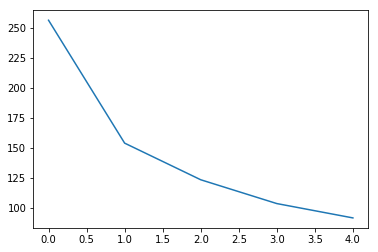

In [8]:
class TwoLayerClassifier(nn.Module):
    def __init__(self, width=28, height=28):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(width * height, 50), nn.ReLU(), nn.Linear(50, 10))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

two_layer_model = TwoLayerClassifier()
train(two_layer_model, training_data_set, test_data_set, epoch_count=5)

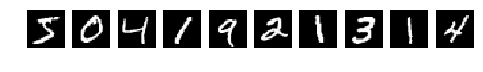

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [9]:
predict(two_layer_model, training_data_set, range(10))

[Epoch 0] Training loss: 151.29384486190975
[Epoch 0] Accuracy: 58283/60000 (97.14%)
[Epoch 1] Training loss: 52.03362734382972
[Epoch 1] Accuracy: 58576/60000 (97.63%)
[Epoch 2] Training loss: 40.34244355512783
[Epoch 2] Accuracy: 59078/60000 (98.46%)
[Epoch 3] Training loss: 32.16316240793094
[Epoch 3] Accuracy: 59086/60000 (98.48%)
[Epoch 4] Training loss: 30.165033514844254
[Epoch 4] Accuracy: 59265/60000 (98.78%)


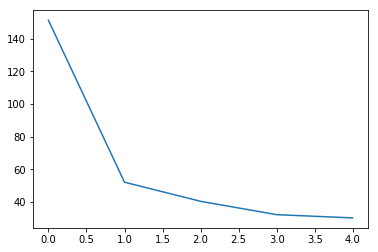

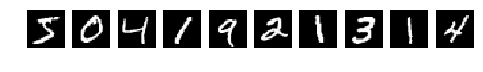

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [11]:
# Always create your models by creating a vector representing several samples
# test_entries = torch.zeros(3, 1, 28, 28)

class ConvolutionalClassifier(nn.Module):
    def __init__(self, width=28, height=28):
        super().__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels=1,   # Just one color channel here
                              out_channels=10, # How many channels do you want as output
                              kernel_size=5,   # Size of the convolutional layer
                              stride=1,        # Size of the step
                              padding=0),
                    nn.MaxPool2d(kernel_size=2),
                    nn.ReLU())
        self.fc = nn.Linear(self.convolution_output_length(width, height), 10)
        self.softmax = nn.Softmax(dim=-1)
    
    def convolution_output_shape(self, width, height):
        xs = self.conv(torch.zeros(1, 1, width, height)) # One sample, with one channel, of size 28 times 28
        return xs.shape
    
    def convolution_output_length(self, width, height):
        # Never hardcode that kind of stuff, compute it!
        length = 1
        for d in self.convolution_output_shape(width, height):
            length *= d
        return length
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = self.conv(xs)
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

convolutional_model = ConvolutionalClassifier()
train(convolutional_model, training_data_set, test_data_set, epoch_count=5)
predict(convolutional_model, training_data_set, range(10))

In [12]:
# TODO - now the hard part is to:
# 1. create a data set in which the images are bigger, and the number might be at different places
# 2. data augmentation: the data might be slightly wrong with noise

from PIL import Image

class MNIST_Noised(Dataset):    
    def __init__(self, images=None, targets=None):
        super().__init__()
        self.images = images or []
        self.targets = targets or []
        self.transform = pipeline
    
    def add_image(self, image, target):
        self.images.append(image)
        self.targets.append(target)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        if isinstance(index, slice):
            return [self.transform(img) for img in self.images[index]], self.targets[index]
        else:
            return self.transform(self.images[index]), self.targets[index]
    
    def get_raw_at(self, index):
        return self.images[index]

def add_noise_to_dataset(dataset):
    dataset.transform = None
    noised_data_set = MNIST_Noised()
    for image, target in dataset:
        resized = Image.new('L', (60, 60), color='black')
        offset_x, offset_y = np.random.randint(0, 31, size=2)
        resized.paste(image, box=(offset_x, offset_y))
        noised_data_set.add_image(resized, target)
    return noised_data_set
    
noised_training_data_set = add_noise_to_dataset(training_data_set)
noised_test_data_set = add_noise_to_dataset(training_data_set)
print('Done creating noised data sets')

Done creating noised data sets


([tensor([[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         ...,
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]]), tensor([[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         ...,
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]])], [tensor(5), tensor(0)])
([tensor([[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5

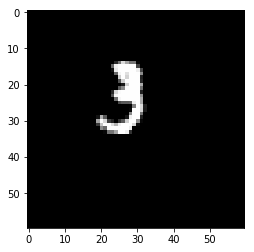

In [13]:
plt.imshow(noised_training_data_set.get_raw_at(10))
print(noised_training_data_set[:2])
print(noised_test_data_set[:2])

[Epoch 0] Training loss: 1610.2289509773254
[Epoch 0] Accuracy: 8990/60000 (14.98%)
[Epoch 1] Training loss: 1432.823870897293
[Epoch 1] Accuracy: 9857/60000 (16.43%)
[Epoch 2] Training loss: 1435.4284545183182
[Epoch 2] Accuracy: 11270/60000 (18.78%)
[Epoch 3] Training loss: 1416.2636014223099
[Epoch 3] Accuracy: 13376/60000 (22.29%)
[Epoch 4] Training loss: 1384.7999229431152
[Epoch 4] Accuracy: 15002/60000 (25.00%)


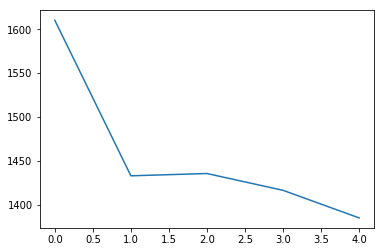

In [14]:
linear_model_2 = LinearClassifier(width=60, height=60)
train(linear_model_2, noised_training_data_set, noised_test_data_set, epoch_count=5)

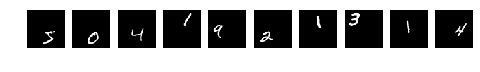

[5, 0, 4, 1, 9, 2, 1, 2, 1, 1]


In [15]:
noised_training_data_set.transform = lambda x: x
predict(linear_model_2, noised_training_data_set, range(10))
noised_training_data_set.transform = pipeline

[Epoch 0] Training loss: 1386.6171662807465
[Epoch 0] Accuracy: 6742/60000 (11.24%)
[Epoch 1] Training loss: 1380.7781500816345
[Epoch 1] Accuracy: 6742/60000 (11.24%)
[Epoch 2] Training loss: 1380.764130115509
[Epoch 2] Accuracy: 6742/60000 (11.24%)
[Epoch 3] Training loss: 1380.762948513031
[Epoch 3] Accuracy: 6742/60000 (11.24%)
[Epoch 4] Training loss: 1380.763822555542
[Epoch 4] Accuracy: 6742/60000 (11.24%)


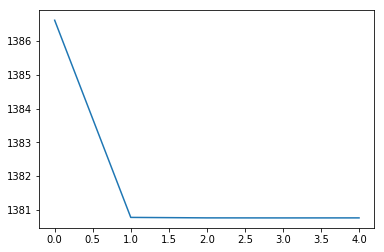

In [17]:
two_layer_model_2 = TwoLayerClassifier(width=60, height=60)
train(two_layer_model_2, noised_training_data_set, noised_test_data_set, epoch_count=5)

[Epoch 0] Training loss: 988.0478149652481
[Epoch 0] Accuracy: 34889/60000 (58.15%)
[Epoch 1] Training loss: 648.0120854973793
[Epoch 1] Accuracy: 42073/60000 (70.12%)
[Epoch 2] Training loss: 559.9144990444183
[Epoch 2] Accuracy: 42887/60000 (71.48%)
[Epoch 3] Training loss: 513.9090113639832
[Epoch 3] Accuracy: 45160/60000 (75.27%)
[Epoch 4] Training loss: 484.86781430244446
[Epoch 4] Accuracy: 46040/60000 (76.73%)
[Epoch 5] Training loss: 459.92392161488533
[Epoch 5] Accuracy: 46780/60000 (77.97%)
[Epoch 6] Training loss: 437.98814076185226
[Epoch 6] Accuracy: 47590/60000 (79.32%)
[Epoch 7] Training loss: 413.53015688061714
[Epoch 7] Accuracy: 47522/60000 (79.20%)
[Epoch 8] Training loss: 398.71949595212936
[Epoch 8] Accuracy: 49006/60000 (81.68%)
[Epoch 9] Training loss: 383.62344816327095
[Epoch 9] Accuracy: 49007/60000 (81.68%)


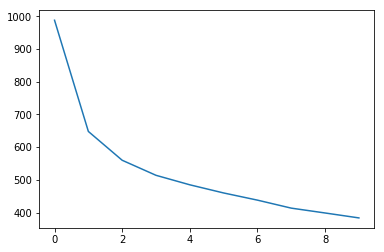

In [21]:
convolutional_model_2 = ConvolutionalClassifier(width=60, height=60)
train(convolutional_model_2, noised_training_data_set, noised_test_data_set, epoch_count=10)

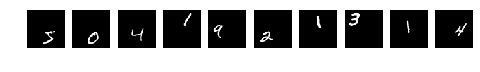

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [19]:
noised_training_data_set.transform = lambda x: x
predict(convolutional_model_2, noised_training_data_set, range(10))
noised_training_data_set.transform = pipeline

[Epoch 0] Training loss: 777.1195952296257
[Epoch 0] Accuracy: 46509/60000 (77.52%)
[Epoch 1] Training loss: 338.7238697707653
[Epoch 1] Accuracy: 51547/60000 (85.91%)
[Epoch 2] Training loss: 242.69836144149303
[Epoch 2] Accuracy: 53866/60000 (89.78%)
[Epoch 3] Training loss: 200.92666453123093
[Epoch 3] Accuracy: 55073/60000 (91.79%)
[Epoch 4] Training loss: 180.99933497607708
[Epoch 4] Accuracy: 55222/60000 (92.04%)
[Epoch 5] Training loss: 164.24345266073942
[Epoch 5] Accuracy: 55782/60000 (92.97%)
[Epoch 6] Training loss: 151.1928461715579
[Epoch 6] Accuracy: 56225/60000 (93.71%)
[Epoch 7] Training loss: 143.05749583244324
[Epoch 7] Accuracy: 56388/60000 (93.98%)
[Epoch 8] Training loss: 133.352735131979
[Epoch 8] Accuracy: 56520/60000 (94.20%)
[Epoch 9] Training loss: 127.88614606112242
[Epoch 9] Accuracy: 56897/60000 (94.83%)


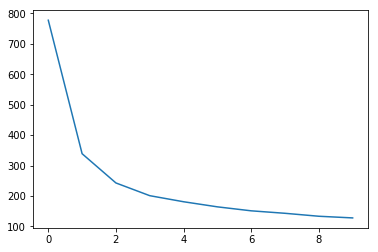

In [23]:
"""
Trying to improve the model (enhance its capacity) to improve the performance on the noised data set
"""

class ConvolutionalClassifier2(nn.Module):
    def __init__(self, width=28, height=28):
        super().__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=0),
                    nn.MaxPool2d(kernel_size=2),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=10, out_channels=5, kernel_size=5, stride=1, padding=0),
                    nn.MaxPool2d(kernel_size=2),
                    nn.ReLU())
        self.fc = nn.Linear(self.convolution_output_length(width, height), 10)
        self.softmax = nn.Softmax(dim=-1)
    
    def convolution_output_shape(self, width, height):
        xs = self.conv(torch.zeros(1, 1, width, height)) # One sample, with one channel, of size 28 times 28
        return xs.shape
    
    def convolution_output_length(self, width, height):
        # Never hardcode that kind of stuff, compute it!
        length = 1
        for d in self.convolution_output_shape(width, height):
            length *= d
        return length
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = self.conv(xs)
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

convolutional_model_3 = ConvolutionalClassifier2(width=60, height=60)
train(convolutional_model_3, noised_training_data_set, noised_test_data_set, epoch_count=10)

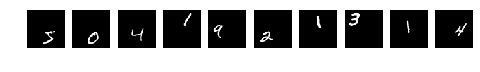

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [24]:
noised_training_data_set.transform = lambda x: x
predict(convolutional_model_3, noised_training_data_set, range(10))
noised_training_data_set.transform = pipeline

Training data set size: 6742
[Iteration 0] Discriminator loss: 0.6799213886260986
[Iteration 0] Generator loss: 0.6423954367637634
[Iteration 100] Discriminator loss: 0.04704025760293007
[Iteration 100] Generator loss: 2.9010281562805176
[Iteration 200] Discriminator loss: 0.006991008296608925
[Iteration 200] Generator loss: 4.62969446182251
[Iteration 300] Discriminator loss: 0.004526684992015362
[Iteration 300] Generator loss: 5.317010402679443
[Iteration 400] Discriminator loss: 0.0037812248338013887
[Iteration 400] Generator loss: 5.1466875076293945
[Iteration 500] Discriminator loss: 0.0018182994099333882
[Iteration 500] Generator loss: 5.932746410369873
[Iteration 600] Discriminator loss: 0.0036615740973502398
[Iteration 600] Generator loss: 5.398202896118164
[Iteration 700] Discriminator loss: 0.0009059736039489508
[Iteration 700] Generator loss: 6.532566547393799
[Iteration 800] Discriminator loss: 0.0006244968972168863
[Iteration 800] Generator loss: 7.073177337646484
[Iterati

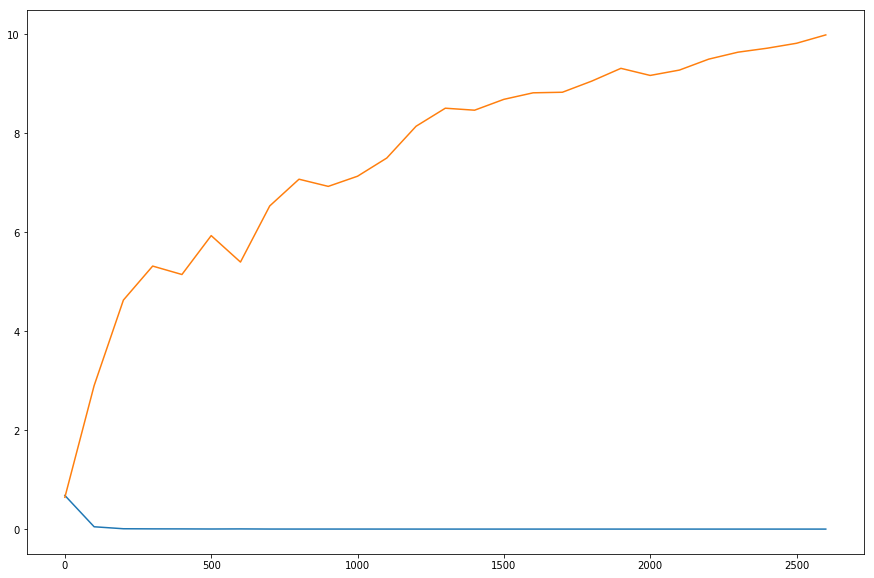

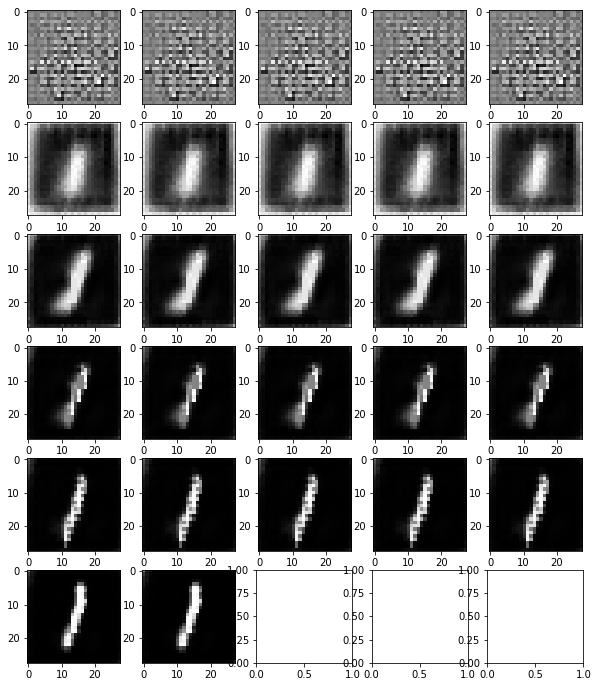

In [30]:
"""
NOW for the really fun part: trying to generate numbers using a GAN
"""

class NumberDiscriminator(nn.Module):
    
    # Note: you need something like a convolutional network to be able to correctly discriminate fakes
    # The simple Linear layer below will not be able to help you much (we saw before that it is very sensitive to positions)
    
    '''
    def __init__(self, width=28, height=28):
        super().__init__()
        self.fc = nn.Linear(width * height, 1) # One entry for fakes
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, xs, with_sigmoid=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_sigmoid:
            xs = self.sigmoid(xs)
        else:
            xs = xs.squeeze(dim=-1)
        return xs
    '''
    
    def __init__(self, width=28, height=28):
        super().__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=0),
                    nn.MaxPool2d(kernel_size=2),
                    nn.ReLU())
        self.fc = nn.Linear(self.convolution_output_length(width, height), 1)
        self.sigmoid = nn.Sigmoid()
    
    def convolution_output_shape(self, width, height):
        xs = self.conv(torch.zeros(1, 1, width, height))
        return xs.shape
    
    def convolution_output_length(self, width, height):
        length = 1
        for d in self.convolution_output_shape(width, height):
            length *= d
        return length
    
    def forward(self, xs, with_sigmoid=True):
        batch_size, channels, width, height = xs.shape
        xs = self.conv(xs)
        xs = self.fc(xs.reshape((batch_size, -1)))
        return self.sigmoid(xs) if with_sigmoid else xs.squeeze(dim=-1)

class NumberGenerator(nn.Module):
    def __init__(self, seed_size, width=28, height=28):
        super().__init__()
        self.seed_size = seed_size
        self.inv_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.seed_size, out_channels=self.seed_size * 2, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=self.seed_size * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=self.seed_size * 2, out_channels=self.seed_size, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=self.seed_size),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=self.seed_size, out_channels=8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh())
            
    def forward(self, xs):
        batch_size, seed_size, width, height = xs.shape
        xs = self.inv_conv(xs)
        return xs
    
    def random_seed(self, batch_size):
        return torch.randn((batch_size, self.seed_size, 1, 1))

@dataclasses.dataclass(frozen=False)
class GanTrainingResult:
    iteration : List[int]
    discriminator_losses : List[float]
    generator_losses : List[float]
    generator_examples : List[Any]
        
def train_gan(generator, discriminator, real_data_set,
              epoch_count=10, batch_size=100, reporting_every=10) -> GanTrainingResult:
    print("Training data set size:", len(real_data_set))
    report = GanTrainingResult(iteration=[], discriminator_losses=[], generator_losses=[], generator_examples=[])
    
    dis_criterion = nn.BCEWithLogitsLoss()
    gen_optimizer = optim.Adam(params=generator.parameters(), lr=1e-3)
    dis_optimizer = optim.Adam(params=discriminator.parameters(), lr=1e-3)
    data_loader = DataLoader(real_data_set, batch_size=batch_size, shuffle=True)
    
    iter_nb = 0
    for epoch in range(epoch_count):
        for real_data, _ in data_loader:
            nb_data = len(real_data)
            dis_cumulative_loss = 0.
            gen_cumulative_loss = 0.
        
            # Generating some random inputs in addition to the normal inputs

            seeds = generator.random_seed(nb_data)
            generated = generator(seeds)
            real_labels = torch.ones((nb_data,))
            fake_labels = torch.zeros((nb_data,))

            # Training the discriminator (real batch then fake batch)

            generator.eval()
            discriminator.train()

            dis_batch = torch.cat((real_data, generated.detach()), dim=0)
            dis_labels = torch.cat((real_labels, fake_labels), dim=0)
            dis_optimizer.zero_grad()
            dis_outputs = discriminator(dis_batch, with_sigmoid=False)
            dis_loss = dis_criterion(dis_outputs, dis_labels)
            dis_loss.backward()
            dis_optimizer.step()
            dis_cumulative_loss += dis_loss.item()

            # Training the generator

            generator.train()
            discriminator.train()

            gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            dis_outputs = discriminator(generated, with_sigmoid=False)
            dis_loss = dis_criterion(dis_outputs, real_labels)
            dis_loss.backward()
            gen_optimizer.step()
            gen_cumulative_loss += dis_loss.item()

            # Reporting the results (loss + example of generation)
            
            if iter_nb % reporting_every == 0:
                report.iteration.append(iter_nb)
                report.discriminator_losses.append(dis_cumulative_loss)
                report.generator_losses.append(gen_cumulative_loss)
                report.generator_examples.append(generated[0].detach())
                print("[Iteration {0}] Discriminator loss: {1}".format(iter_nb, dis_cumulative_loss))
                print("[Iteration {0}] Generator loss: {1}".format(iter_nb, gen_cumulative_loss))
            iter_nb += 1
    
    generator.eval()
    discriminator.eval()
    return report

def filter_value(data_set, chosen_val):
    xs = []
    ys = []
    data_set.transform = pipeline
    for image, target in data_set:
        if target.item() == chosen_val:
            xs.append(torch.clone(image))
            ys.append(target)
    return TensorDataset(torch.stack(xs), torch.stack(ys))

def show_sample(generated):
    image = generated.squeeze(dim=0).squeeze(dim=0).detach().numpy()
    max_val = image.max()
    min_val = image.min()
    image = (image - min_val) / (max_val - min_val)
    image = np.uint8(image * 255)
    return Image.fromarray(image, 'L')

'''
generator = NumberGenerator(seed_size=100)
seed = generator.random_seed(1)
print(seed.shape)
output = generator(seed)
print(output.shape)
'''

# '''
generator = NumberGenerator(seed_size=64)
discriminator = NumberDiscriminator()
training_data_set.transform = pipeline
report = train_gan(generator, discriminator, filter_value(training_data_set, 1), epoch_count=100, batch_size=250, reporting_every=100)
# report = train_gan(generator, discriminator, filter_value(training_data_set, 1), epoch_count=1, batch_size=500, reporting_every=1)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(report.iteration, report.discriminator_losses)
ax.plot(report.iteration, report.generator_losses)
plt.show()

nb_cols = 5
full_rows, remaining = divmod(len(report.iteration), nb_cols)
nb_rows = full_rows + (1 if remaining else 0)
fig, ax = plt.subplots(figsize=(10, 2 * nb_rows), ncols=nb_cols, nrows=nb_rows)
for sample_i in range(len(report.iteration)):
    i, j = divmod(sample_i, nb_cols)
    example = report.generator_examples[i]
    ax[(i, j)].imshow(show_sample(example))
plt.show()
# '''

# TODO - for the moment, the generator is not able to keep up with the discriminator